dataset_type = train | test | validation

In [1]:
from datasets import load_dataset
import json, pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [2]:
dataset_type = "validation"
FILTERED_FILE_PATH =f"./comet_{dataset_type}.json"

In [3]:
comet = None
with open(FILTERED_FILE_PATH) as f:
    comet = json.loads(f.read())

In [4]:
samsum = load_dataset('samsum')

In [5]:
summary_dict = dict([(obj["id"], obj["summary"]) for obj in samsum[dataset_type]])

In [6]:
cs_unraveled = []
for sample_id, sammple_cs in comet.items():
    for sentence_num, sentence_obj in enumerate(sammple_cs):
        for cs_key_or_sentence, cs_arr_or_sentence in sentence_obj.items():
            if type(cs_arr_or_sentence) == type([]):
                for cs in cs_arr_or_sentence:
                    cs_unraveled.append({"sample_id":sample_id,"sentence_id":sentence_num, \
                    "sentence":sentence_obj["sentence"], "cs_type":cs_key_or_sentence, "cs":cs, "summary":summary_dict[sample_id]})

In [7]:
len([obj["sentence"] for obj in cs_unraveled]) == sum([len(sentences) for _, sentences in comet.items()])*25

True

### Model details:
https://github.com/UKPLab/sentence-transformers

In [8]:
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [9]:
cs_unraveled[0]

{'sample_id': '13594102-1',
 'sentence_id': 0,
 'sentence': 'Good morning!',
 'cs_type': 'HinderedBy',
 'cs': " Steve doesn't want to be rude.",
 'summary': 'Steve is picking Anton up. Anton is running late.'}

In [14]:
cs_final= []
for cs_obj in tqdm(cs_unraveled):
    cs_emb =  sbert.encode(cs_obj["cs"])
    summary_emb = sbert.encode(cs_obj["summary"])
    cs_final.append({**cs_obj,"cs_encoded":cs_emb, "sumary_encoded":summary_emb, "cos_similary":float(util.cos_sim(cs_emb, summary_emb))})

100%|██████████| 10000/10000 [02:52<00:00, 58.07it/s]


In [15]:
cs_dp = pd.DataFrame(cs_final)

In [20]:
len(cs_dp)/25

400.0

In [37]:
peaks = [max(list(cs_dp["cos_similary"])[25*(i-1):25*i]) for i in range(1,400)]

In [39]:
import numpy as np 
np.average(peaks)

0.42013306153896157

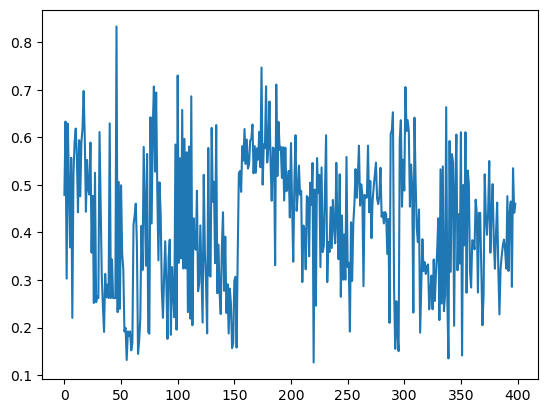

In [38]:
import matplotlib.pyplot as plt
plt.plot(peaks)